In [1]:
using PowerModelsDistribution
using Plots, SCIP, Alpine
using Ipopt
using JuMP
using NBInclude
@nbinclude("add_generators_to_load_buses.ipynb")
@nbinclude("plot_network.ipynb")
@nbinclude("power_network.ipynb")


silence!()
;

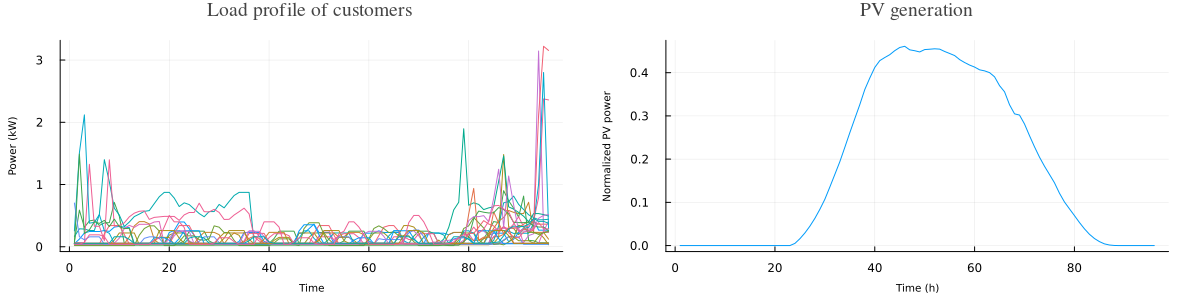

In [2]:
V_min = 0.95
V_max = 1.05
P_max = 12.0
Q_max = P_max
pf = 0.95

η = sqrt(1/pf^2-1)
ν = 0.95

pn = power_network("feeder 5")
eng = pn.eng

add_generators_to_load_buses!(eng, -P_max, P_max, -Q_max, Q_max)

data_math = transform_data_model(eng)
load_profiles = pn.load_profiles
pv_profile = pn.pv_profile
T, L = size(load_profiles) # T: number of time steps, N: number of load points

# Predefine the layout
plt = plot(layout = (1, 2), size = (1200, 300), legend = false, 
           titlefont = "Times", margin = 6 * Plots.mm, 
           ylabelfontsize = 7, xlabelfontsize = 7, titlefontsize = 12)

# Plot the first subplot using plot_load_profiles!
plot_load_profiles!(pn, subplot = 1)

# Plot the second subplot
plot!(subplot = 2, collect(pv_profile[:, 1]), 
      title = "PV generation", xlabel = "Time (h)", ylabel = "Normalized PV power")

display(plt)



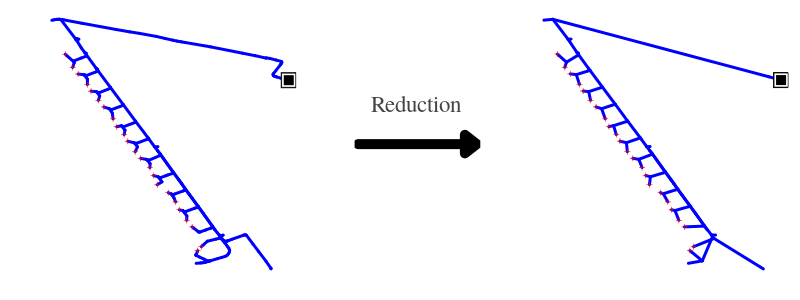

In [3]:
plot_reduced_and_original(pn)

In [122]:
# Define time_series for each load
time_series_data = Dict{String, Any}()

for (i, load_profile) in enumerate(eachcol(load_profiles))
    ts_name = "load_$(i)_series"  # Unique time_series name
    time_series_data[ts_name] = Dict(
        "time" => collect(1:T),           # Time steps (1 to T)
        "values" => load_profile,        # The load profile for this load
        "offset" => 0.0,                 # Start time offset (default = 0.0 hours)
        "replace" => true                # Replace load value instead of scaling
    )
end

# Add the time_series dictionary to the top-level of data_math
data_math["time_series"] = time_series_data

# Define the total number of time steps
data_math["time_series"]["num_steps"] = T  # Total number of time slots (e.g., 96 for 15-min intervals)

# Create the multi-network
multi_network = make_multinetwork(data_math; time_elapsed=Δt)  # Δt is the time step in hours
;

In [123]:
# adjust loads in the multi-network
for t in 1:T
    for load_id in keys(multi_network["nw"]["$t"]["load"])
        # Set the active power ("pd") for this load at time step `t`
        multi_network["nw"]["$t"]["load"][load_id]["pd"] *= LMF*load_profiles[t, load_id]
        multi_network["nw"]["$t"]["load"][load_id]["qd"] *= LMF*load_profiles[t, load_id]
    end
end
#

In [124]:
S_base = multi_network["nw"]["1"]["settings"]["sbase"]
# Iterate through each network and adjust generator limits
for (network_id, network_data) in multi_network["nw"]
    for (gen_id, gen_data) in network_data["gen"]
        if startswith(gen_data["name"], "gen_")  # Identify generators
            # Adjust upper bound based on the PV profile for the corresponding time step
            time_step = parse(Int, network_id)  # Network index corresponds to time step
            # Update generator limits
            gen_data["pmax"] .+= pv_profile[time_step, 1]*PV_size / S_base # Add PV generation for the time slot
            gen_data["pmin"] .+= pv_profile[time_step, 1]*PV_size / S_base # Add PV generation for the time slot
        end
    end
end

In [125]:
##############################################################################################
######################################################     NETWORK, SETS, and PARAMETERS
##############################################################################################
pm = instantiate_mc_model(multi_network, ACPUPowerModel, build_mn_mc_opf, multinetwork=true)

gen_keys = filter( gen_id -> startswith(ref(pm, 1, :gen, gen_id)["name"], "gen_"), keys(ref(pm, 1, :gen)) )
bus_keys = keys(ref(pm, 1, :bus))
# Initialize the lookup dictionary
g2l = Dict{Int, Int}()

# Extract all generator and load indices for the network
load_keys = keys(ref(pm, 1, :load))

# Create a mapping
for gen_id in gen_keys
    gen_bus = ref(pm, 1, :gen, gen_id)["gen_bus"]
    for load_id in load_keys
        load_bus = ref(pm, 1, :load, load_id)["load_bus"]
        if gen_bus == load_bus
            g2l[gen_id] = load_id
            break
        end
    end
end

##############################################################################################
######################################################          VARIABLES
##############################################################################################
@variable(pm.model, OB)
@variable(pm.model, OB2_v2 >= 0)
@variable(pm.model, OB3_v1 >= 0)

# Add flexibility variables to the model
@variable(pm.model, 2*P_max/S_base >= ΔP_flex_p[n=1:T, l=gen_keys] >= 0)  # Positive flexibility per load and time
@variable(pm.model, 2*P_max/S_base >= ΔP_flex_n[n=1:T, l=gen_keys] >= 0)  # Negative flexibility per load and time
@variable(pm.model, 2*Q_max/S_base >= ΔQ_flex_p[n=1:T, l=gen_keys] >= 0)  # Positive flexibility per load and time
@variable(pm.model, 2*Q_max/S_base >= ΔQ_flex_n[n=1:T, l=gen_keys] >= 0)  # Negative flexibility per load and time

# Add energy flexibility variables to the model
@variable(pm.model, E_flex_p[l=gen_keys] >= 0)    # Total positive energy flexibility per load
@variable(pm.model, E_flex_n[l=gen_keys] >= 0)    # Total negative energy flexibility per load
@variable(pm.model, QE_flex_p[l=gen_keys] >= 0)   # Total positive energy flexibility per load
@variable(pm.model, QE_flex_n[l=gen_keys] >= 0)   # Total negative energy flexibility per load

# Add auxiliary variable for voltage magnitude deviation
@variable(pm.model, θ[n in 1:T, b in bus_keys, ϕ in ref(pm, 1, :bus, b)["terminals"]] >=0)

if ω3_v1 != 0
    # Variables for McCormick relaxation
    @variable(pm.model, P_max >= P[n in 1:T, l=gen_keys] >= -P_max)
    @variable(pm.model, Q_max >= Q[n in 1:T, l=gen_keys] >= -Q_max)
    @variable(pm.model, y1[n in 1:T, l=gen_keys] >=0)
    @variable(pm.model, y2[n in 1:T, l=gen_keys] >=0)
    @variable(pm.model, ζ1[n in 1:T, l=gen_keys], Bin)
    @variable(pm.model, ζ2[n in 1:T, l=gen_keys], Bin)
    @variable(pm.model, Ψ[n in 1:T, l=gen_keys] >=0)
end
##############################################################################################
######################################################          OBJECTIVES
##############################################################################################
@objective(pm.model, Min, OB)
@constraint(pm.model, OB >= ω1*sum(λD*E_flex_p .+ λU*E_flex_n) +
                            ω2*sum(θ) +
                            OB2_v2 +
                            OB3_v1 +
                            ω3_v2*sum(λiD*QE_flex_p .+ λiU*QE_flex_n)
          )
          
##############################################################################################
######################################################          CONSTRAINTS
##############################################################################################
# constraints 1 and 2 and similar equations also for Q
@constraint(pm.model, flex_p[n in keys(nws(pm)), l in gen_keys], PowerModelsDistribution.var(pm, n, :pg, l)[ref(pm, n, :gen, l, "connections")] .== ΔP_flex_p[n,l] .- ΔP_flex_n[n,l])
@constraint(pm.model, flex_E_p[l in gen_keys], sum(ΔP_flex_p[n,l] for n in keys(nws(pm)))*Δt .==  E_flex_p[l])
@constraint(pm.model, flex_E_n[l in gen_keys], sum(ΔP_flex_n[n,l] for n in keys(nws(pm)))*Δt .==  E_flex_n[l])
@constraint(pm.model, flex_q[n in keys(nws(pm)), l in gen_keys], PowerModelsDistribution.var(pm, n, :qg, l)[ref(pm, n, :gen, l, "connections")] .== ΔQ_flex_p[n,l] .- ΔQ_flex_n[n,l])
@constraint(pm.model, flex_QE_p[l in gen_keys], sum(ΔQ_flex_p[n,l] for n in keys(nws(pm)))*Δt .==  QE_flex_p[l])
@constraint(pm.model, flex_QE_n[l in gen_keys], sum(ΔQ_flex_n[n,l] for n in keys(nws(pm)))*Δt .==  QE_flex_n[l])

# constraints 7a and 7b
@constraint(pm.model, VUF1[n in keys(nws(pm)), b in bus_keys, ϕ in ref(pm, n, :bus, b)["terminals"]], 
            θ[n,b,ϕ] >= PowerModelsDistribution.var(pm, n, :vm, b)[ϕ] - 1/3*sum(PowerModelsDistribution.var(pm, n, :vm, b)))
@constraint(pm.model, VUF2[n in keys(nws(pm)), b in bus_keys, ϕ in ref(pm, n, :bus, b)["terminals"]], 
            θ[n,b,ϕ] >= -PowerModelsDistribution.var(pm, n, :vm, b)[ϕ] + 1/3*sum(PowerModelsDistribution.var(pm, n, :vm, b)))

# One added constraint according to OB-V2_ln
@constraint(pm.model, θ .+ ϵ .<= U_lim )

if ω2_v2 != 0
    @constraint(pm.model, OB2_v2 == -ω2_v2*sum(log.(U_lim .- θ)))
    println("OB2_v2 added.")
end

if ω3_v1 != 0
    @constraint(pm.model, OB3_v1 == ω3_v1*sum(Ψ))
    # P and Q calculation for loads
    @constraint(pm.model, cal_p[n in keys(nws(pm)), l in gen_keys], 
    ref(pm, n, :load, g2l[l])["pd"] .- PowerModelsDistribution.var(pm, n, :pg, l)[ref(pm, n, :gen, l, "connections")] .== P[n, l])
    @constraint(pm.model, cal_q[n in keys(nws(pm)), l in gen_keys], 
    ref(pm, n, :load, g2l[l])["qd"] .- PowerModelsDistribution.var(pm, n, :qg, l)[ref(pm, n, :gen, l, "connections")] .== Q[n, l])


    # McCormick CONSTRAINTS
    @constraint(pm.model, MC21, Ψ .>= λ_s*(2*y1 .- Q .- 2*k*y2 .+ k*P))
    @constraint(pm.model, MC22, 2*y2 .- Q .>=  0)
    @constraint(pm.model, MC23, 2*y2 .- P .>=  0)
    @constraint(pm.model, MC24, y1 .>= -Q_max.*ζ1)
    @constraint(pm.model, MC25, y1 .<=  Q_max.*ζ1)
    @constraint(pm.model, MC26, y2 .>= -P_max.*ζ2)
    @constraint(pm.model, MC27, y2 .<=  P_max.*ζ2)
    @constraint(pm.model, MC28, y1 .>= Q .+ Q_max*(ζ1.-1))
    @constraint(pm.model, MC29, y1 .<= Q .- Q_max*(ζ1.-1))
    @constraint(pm.model, MC30, y2 .>= P .+ P_max*(ζ2.-1))
    @constraint(pm.model, MC31, y2 .<= P .- P_max*(ζ2.-1))

    println("OB3_v1 added.")
end
;

In [126]:
using Juniper, HiGHS
# Set Ipopt as the optimizer
ipopt = optimizer_with_attributes(Ipopt.Optimizer, "tol" => 1e-6, "print_level" => 0)
highs = optimizer_with_attributes(HiGHS.Optimizer)
juniper = optimizer_with_attributes(
    Juniper.Optimizer,
    "nl_solver" => ipopt,
    "mip_solver" => highs,
)
if ω3_v1 != 0
    set_optimizer(pm.model, juniper)
else
    set_optimizer(pm.model, ipopt)
end
                               
# Solve the optimization problem
optimize!(pm.model)
;